In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/Colab Notebooks/02 - Time Series/

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/02 - Time Series


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import ccovf,ccf,periodogram
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin
from statsmodels.tools.eval_measures import mse, rmse, meanabs
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Load a seasonal dataset
df1 = pd.read_csv('./data/airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a nonseasonal dataset
df2 = pd.read_csv('./data/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

df3 = pd.read_csv('./data/samples.csv',index_col=0,parse_dates=True)
df3.index.freq = 'MS'

# Tests for Stationarity
A time series is <em>stationary</em> if the mean and variance are fixed between any two equidistant points. That is, no matter where you take your observations, the results should be the same. A times series that shows seasonality is <em>not</em> stationary.

A test for stationarity usually involves a <a href='https://en.wikipedia.org/wiki/Unit_root_test'>unit root</a> hypothesis test, where the null hypothesis $H_0$ is that the series is <em>nonstationary</em>, and contains a unit root. The alternate hypothesis $H_1$ supports stationarity. The <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller</a> and <a href='https://en.wikipedia.org/wiki/KPSS_test'>Kwiatkowski-Phillips-Schmidt-Shin</a> tests are stationarity tests. 

## Augmented Dickey-Fuller Test
In this test the null hypothesis states that $\phi = 1$ (this is also called a unit test). The test returns several statistics we'll see in a moment. Our focus is on the p-value. A small p-value ($p<0.05$) indicates strong evidence against the null hypothesis.

In [ ]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

Augmented Dickey-Fuller Test: 
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


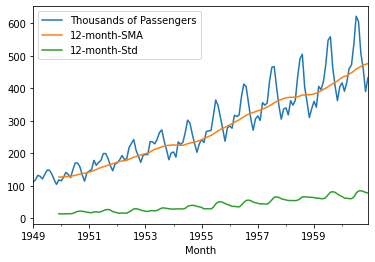

In [ ]:
df1['12-month-SMA'] = df1['Thousands of Passengers'].rolling(window=12).mean()
df1['12-month-Std'] = df1['Thousands of Passengers'].rolling(window=12).std()
df1[['Thousands of Passengers','12-month-SMA','12-month-Std']].plot();
adf_test(df1['Thousands of Passengers'])

Not only is this dataset seasonal with a clear upward trend, the standard deviation increases over time as well.

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.808291
p-value                   0.000052
# lags used               6.000000
# observations          358.000000
critical value (1%)      -3.448749
critical value (5%)      -2.869647
critical value (10%)     -2.571089
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


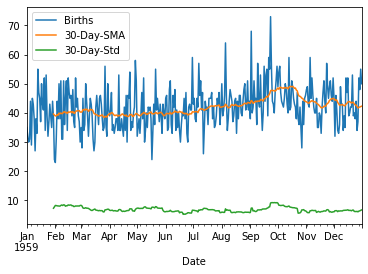

In [ ]:
df2['30-Day-SMA'] = df2['Births'].rolling(window=30).mean()
df2['30-Day-Std'] = df2['Births'].rolling(window=30).std()
df2[['Births','30-Day-SMA','30-Day-Std']].plot();
adf_test(df2['Births'])

# Casuality

## Granger Causality Tests
The <a href='https://en.wikipedia.org/wiki/Granger_causality'>Granger causality test</a> is a a hypothesis test to determine if one time series is useful in forecasting another. While it is fairly easy to measure correlations between series - when one goes up the other goes up, and vice versa - it's another thing to observe changes in one series correlated to changes in another after a consistent amount of time. This <em>may</em> indicate the presence of causality, that changes in the first series influenced the behavior of the second. However, it may also be that both series are affected by some third factor, just at different rates. Still, it can be useful if changes in one series can predict upcoming changes in another, whether there is causality or not. In this case we say that one series "Granger-causes" another.

In the case of two series, $y$ and $x$, the null hypothesis is that lagged values of $x$ do <em>not</em> explain variations in $y$.<br>
In other words, it assumes that $x_t$ doesn’t Granger-cause $y_t$.

The stattools <tt><strong>grangercausalitytests</strong></tt> function offers four tests for granger non-causality of 2 timeseries

For this example we'll use the samples.csv file, where columns 'a' and 'd' are stationary datasets.

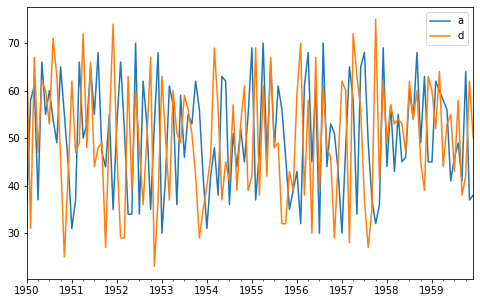

In [ ]:
df3[['a','d']].plot(figsize=(8,5));

The function takes in a 2D array [y,x] and a maximum number of lags to test on x. Here our y is column 'a' and x is column 'd'. We'll set maxlags to 3.

In [ ]:
# Add a semicolon at the end to avoid duplicate output
grangercausalitytests(df3[['a','d']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.7492  , p=0.1860  , df=1
likelihood ratio test: chi2=1.7365  , p=0.1876  , df=1
parameter F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=597.3806, p=0.0000  , df=2
likelihood ratio test: chi2=212.6514, p=0.0000  , df=2
parameter F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=602.2669, p=0.0000  , df=3
likelihood ratio test: chi2=212.4789, p=0.0000  , df=3
parameter F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3


Essentially we're looking for extremely low p-values, which we see at lag 2.<br>

In [ ]:
# Add a semicolon at the end to avoid duplicate output
grangercausalitytests(df3[['b','d']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.5619  , p=0.2114  , df=1
likelihood ratio test: chi2=1.5517  , p=0.2129  , df=1
parameter F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=0.9086  , p=0.6349  , df=2
likelihood ratio test: chi2=0.9051  , p=0.6360  , df=2
parameter F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5333  , p=0.6604  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=1.7018  , p=0.6365  , df=3
likelihood ratio test: chi2=1.6895  , p=0.6393  , df=3
parameter F test:         F=0.5333  , p=0.6604  , df_denom=110, df_num=3


High p-values, b and d has little to no casuality

# Evaluation Metrics

## Forecast Accuracy
Two calculations related to linear regression are <a href='https://en.wikipedia.org/wiki/Mean_squared_error'><strong>mean squared error</strong></a> (MSE) and <a href='https://en.wikipedia.org/wiki/Root-mean-square_deviation'><strong>root mean squared error</strong></a> (RMSE)

The formula for the mean squared error is<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;$MSE = {\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2$<br><br>
where $T$ is the last observation period and $l$ is the lag point up to $L$ number of test observations.

The formula for the root mean squared error is<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;$RMSE = \sqrt{MSE} = \sqrt{{\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2}$<br><br>

The advantage of the RMSE is that it is expressed in the same units as the data.<br><br>

A method similar to the RMSE is the <a href='https://en.wikipedia.org/wiki/Mean_absolute_error'><strong>mean absolute error</strong></a> (MAE) which is the mean of the magnitudes of the error, given as<br><br>

&nbsp;&nbsp;&nbsp;&nbsp;$MAE = {\frac 1 L} \sum\limits_{l=1}^L \mid{y_{T+l}} - \hat y_{T+l}\mid$<br><br>

A forecast method that minimizes the MAE will lead to forecasts of the median, while minimizing the RMSE will lead to forecasts of the mean.

## AIC / BIC
More sophisticated tests include the <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'><strong>Akaike information criterion</strong></a> (AIC) and the <a href='https://en.wikipedia.org/wiki/Bayesian_information_criterion'><strong>Bayesian information criterion</strong></a> (BIC).

The AIC evaluates a collection of models and estimates the quality of each model relative to the others. Penalties are provided for the number of parameters used in an effort to thwart overfitting. The lower the AIC and BIC, the better the model should be at forecasting.

These functions are available as

&nbsp;&nbsp;&nbsp;&nbsp;<tt>from from statsmodels.tools.eval_measures import aic, bic</tt>

but we seldom compute them alone as they are built into many of the statsmodels tools we use.